<a href="https://colab.research.google.com/github/yuannnnn/DATS6501/blob/main/Disastersvgg16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Loading & Processing

In [ ]:
from google.colab import drive
import sys

# Mount Google Drive
drive.mount('/content/drive')

curr = '/content/drive/My Drive/Colab Notebooks/'

Mounted at /content/drive


In [ ]:
import os

if "crisis_vision_benchmarks" not in os.listdir():
    os.system("wget https://crisisnlp.qcri.org/data/crisis_image_datasets_benchmarks/crisis_vision_benchmarks.tar.gz")
    os.system("tar xf crisis_vision_benchmarks.tar.gz")

In [ ]:
import pandas as pd
from PIL import Image
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader

class CustomImageDataset(Dataset):
    def __init__(self, path, transform=None):
        self.pre = os.getcwd() + "/crisis_vision_benchmarks"
        path = pd.read_csv(path, sep='\t')
        image_path, class_label = path['image_path'], path['class_label']
        self.img, lab = [], []
        for i in range(len(class_label)):
          if class_label[i] != 'other_disaster':
            self.img.append(image_path[i])
            lab.append(class_label[i])
        self.le = LabelEncoder()
        self.le.fit(lab)
        self.labels = self.le.transform(lab)
        self.transform = transform

    def __len__(self):
        return len(self.img)

    def le(self):
        return self.le

    def __getitem__(self, idx):
        img_path = os.path.join(self.pre, self.img[idx])
        with open(img_path, 'rb') as f:
          img = Image.open(f) 
          image = img.convert('RGB')
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

In [ ]:
import torch
import torch.nn as nn
import torchvision
from torchvision import models, transforms

# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    "train": transforms.Compose([
        transforms.RandomResizedCrop([299,299]),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    "dev": transforms.Compose([
        transforms.Resize([310,310]),
        transforms.CenterCrop([299,299]),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

types_root = "/content/crisis_vision_benchmarks/tasks/disaster_types/consolidated/consolidated_disaster_types_"

types_dataset = {x: CustomImageDataset(types_root + x + "_final.tsv", data_transforms[x])
                  for x in ["train", "dev"]}

types_loader = {x: DataLoader(types_dataset[x], batch_size=64,
                                             shuffle=True, num_workers=2)
                  for x in ["train", "dev"]}
              
types_size = {x: len(types_dataset[x]) for x in ["train", "dev"]}

types_names = types_dataset['train'].le.classes_

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
types_test = CustomImageDataset(types_root + "test_final.tsv", data_transforms["dev"])

In [ ]:
len(types_dataset["train"]),len(types_dataset["dev"]),len(types_test)

(11714, 1327, 2893)

In [ ]:
types_names

array(['earthquake', 'fire', 'flood', 'hurricane', 'landslide',
       'not_disaster'], dtype='<U12')

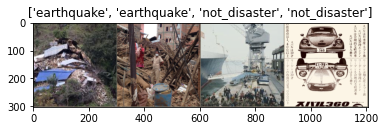

Feature batch shape: torch.Size([64, 3, 299, 299])
Labels batch shape: torch.Size([64])


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0)) # Change the Tensor to array and change color channel to the last
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(types_loader['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs[:4])

imshow(out, title=[types_names[x] for x in classes[:4]])

print(f"Feature batch shape: {inputs.size()}")
print(f"Labels batch shape: {classes.size()}")

# Data Modeling & Training

In [ ]:
import torch.optim as optim
from torch.optim import lr_scheduler

import time
import copy

In [ ]:
def train_types(model, criterion, optimizer, scheduler, num_epochs):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'dev']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in types_loader[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / types_size[phase]
            epoch_acc = running_corrects.double() / types_size[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'dev' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
model_ft = models.vgg16(pretrained=True)
print(model_ft)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
# change the number of classes 
model_ft.classifier[6].out_features = len(types_names)
# freeze convolution weights
for param in model_ft.features.parameters():
    param.requires_grad = False

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.01, momentum=0.9)

# Decay LR by a factor of 0.1 every 5 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=5, gamma=0.1)

In [ ]:
model_types = train_types(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=15)

Epoch 0/14
----------


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


train Loss: 1.1708 Acc: 0.6554
dev Loss: 0.7095 Acc: 0.7476

Epoch 1/14
----------
train Loss: 0.7785 Acc: 0.7359
dev Loss: 0.6332 Acc: 0.7882

Epoch 2/14
----------
train Loss: 0.7037 Acc: 0.7586
dev Loss: 0.6154 Acc: 0.7860

Epoch 3/14
----------
train Loss: 0.6849 Acc: 0.7628
dev Loss: 0.6333 Acc: 0.7769

Epoch 4/14
----------
train Loss: 0.6671 Acc: 0.7719
dev Loss: 0.6741 Acc: 0.7724

Epoch 5/14
----------
train Loss: 0.5926 Acc: 0.7948
dev Loss: 0.5568 Acc: 0.8176

Epoch 6/14
----------
train Loss: 0.5570 Acc: 0.8075
dev Loss: 0.5450 Acc: 0.8214

Epoch 7/14
----------
train Loss: 0.5370 Acc: 0.8159
dev Loss: 0.5444 Acc: 0.8222

Epoch 8/14
----------
train Loss: 0.5264 Acc: 0.8187
dev Loss: 0.5292 Acc: 0.8267

Epoch 9/14
----------
train Loss: 0.5073 Acc: 0.8256
dev Loss: 0.5270 Acc: 0.8304

Epoch 10/14
----------
train Loss: 0.5045 Acc: 0.8272
dev Loss: 0.5249 Acc: 0.8335

Epoch 11/14
----------
train Loss: 0.5091 Acc: 0.8251
dev Loss: 0.5243 Acc: 0.8289

Epoch 12/14
----------
t

In [ ]:
torch.save(model_types.state_dict(), curr+"model_types4.pth")

# Load Trained Net

In [ ]:
model_ft = models.vgg16(pretrained=False)
# change the number of classes 
model_ft.classifier[6].out_features = len(types_names)
# freeze convolution weights
for param in model_ft.features.parameters():
    param.requires_grad = False

model_ft.load_state_dict(torch.load(curr+"model_types4.pth"))

model_ft = model_ft.to(device)

In [ ]:
test_loader = DataLoader(types_test, batch_size=64, shuffle=True, num_workers=2)

In [ ]:
preds, real = [], []
for images, labels in test_loader:
  images, labels = images.to(device), labels.to(device)
  real += labels.tolist()
  with torch.no_grad():
    output = model_ft(images)
    _, predicted = torch.max(output, 1)
    preds += predicted.tolist()

In [ ]:
from sklearn import metrics

In [ ]:
print(metrics.classification_report(real, preds, target_names=types_names))

              precision    recall  f1-score   support

  earthquake       0.80      0.82      0.81       404
        fire       0.84      0.89      0.86       280
       flood       0.82      0.85      0.84       599
   hurricane       0.71      0.64      0.67       352
   landslide       0.76      0.83      0.79       268
not_disaster       0.91      0.88      0.89       990

    accuracy                           0.83      2893
   macro avg       0.81      0.82      0.81      2893
weighted avg       0.83      0.83      0.83      2893



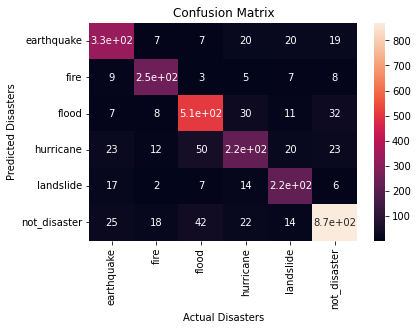

In [ ]:
import seaborn as sns

cm = metrics.confusion_matrix(real, preds)
f = sns.heatmap(cm, annot=True, xticklabels=types_names, yticklabels=types_names)
plt.title("Confusion Matrix")
plt.xlabel("Actual Disasters")
plt.ylabel("Predicted Disasters") 
plt.show()

# Codes borrowed and adjusted from:


1.  [PyTorch Tutorials](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#creating-a-custom-dataset-for-your-files)
2.  [Transfer Learning for Computer Vision Tutorial](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html)
3.  [Transfer Learning with PyTorch](https://debuggercafe.com/transfer-learning-with-pytorch/)


